In [1]:
import os
import json
import numpy as np

from tqdm.notebook import tqdm

from torch import nn
import torch
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader

In [2]:
data_dir = "data"
dataset_id = "20220329222400"

dataset_dir = os.path.join(data_dir, dataset_id)

low_rank = 25

In [3]:
# read embeds, prices, and ids
text_embeds = np.load(os.path.join(dataset_dir, "text_embeds.npy"))
image_embeds = np.load(os.path.join(dataset_dir, "image_embeds.npy"))

embeds = np.concatenate([text_embeds, image_embeds], axis=1)

# Perform SVD on embeds to get low-rank embeds (rank=100)
U, s, V = np.linalg.svd(embeds, full_matrices=False)
embeds = U[:, :low_rank]


embeds = torch.tensor(embeds, dtype=torch.float32)

prices = np.load(os.path.join(dataset_dir, "prices.npy"))
# normalize prices
mean_price = np.mean(prices)
std_price = np.std(prices)
prices = (prices - mean_price) / std_price

def score_to_price(score):
    # undo normalization
    score = score * std_price + mean_price
    return score

prices = torch.tensor(prices, dtype=torch.float32).unsqueeze(dim=1)

ids = np.load(os.path.join(dataset_dir, "ids.npy"))


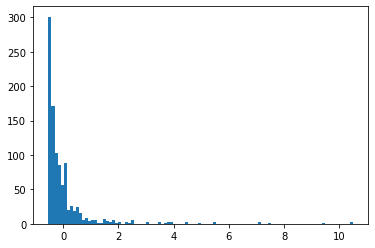

In [4]:
import matplotlib.pyplot as plt

# prices histogram
plt.hist(prices.numpy(), bins=100)
plt.show()



In [5]:
print(text_embeds.shape)
print(image_embeds.shape)
print(embeds.shape)
print(prices.shape)

(995, 512)
(995, 512)
torch.Size([995, 25])
torch.Size([995, 1])


In [35]:
class PriceModel(nn.Module):

    def __init__(self):
        super(PriceModel, self).__init__()
        self.fc1 = nn.Linear(low_rank, low_rank//2)
        self.fc2 = nn.Linear(low_rank//2, 1)
        # self.fc3 = nn.Linear(256, 1)

    def forward(self, embeds): 
        x = F.relu(self.fc1(embeds))
        x = self.fc2(x)
        return x

# class EmbeddedDataset(Dataset):
#     def __init__(self, embeds, prices):
#         self.embeds = embeds
#         self.prices = prices

#     def __len__(self):
#         return len(self.embeds)

#     def __getitem__(self, idx):
#         return self.embeds[idx], self.prices[idx]

In [7]:
train_p, valid_p, test_p = 0.6, 0.2, 0.2

assert train_p + valid_p + test_p == 1, "Train, valid, and test percentages must add up to 1."

n_train = int(len(embeds) * train_p)
n_valid = int(len(embeds) * valid_p)
n_test = len(embeds) - n_train - n_valid

training_data = TensorDataset(embeds[:n_train], prices[:n_train])
validation_data = TensorDataset(embeds[n_train:n_train+n_valid], prices[n_train:n_train+n_valid])
test_data = TensorDataset(embeds[n_train+n_valid:], prices[n_train+n_valid:])


In [44]:
epochs = 1000
batch_size = 256
learning_rate = 1e-3

train_dataloader = DataLoader(training_data, batch_size=batch_size, shuffle=True)
valid_dataloader = DataLoader(validation_data, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=True)

model = PriceModel()
optimzer = torch.optim.Adam(model.parameters(), lr=learning_rate)
loss = nn.MSELoss()

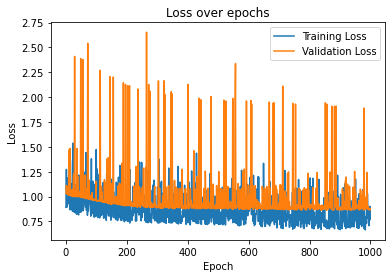

In [45]:
loss_history = []
val_loss_history = []

for epoch in range(epochs):
    # print(f"Epoch {epoch+1}/{epochs}")
    # pbar = tqdm(train_dataloader)
    total_loss = 0
    count = 0

    total_val_loss = 0
    for x, y in train_dataloader:
        model.train()
        preds = model(x)
        output = loss(preds, y)

        optimzer.zero_grad()
        output.backward()
        optimzer.step()

        total_loss += output.item()
        count += 1

    loss_history.append(total_loss / count)

    count = 0
    with torch.no_grad():

        for x, y in valid_dataloader:
            model.eval()
            preds = model(x)
            output = loss(preds, y)

            total_val_loss += output.item()
            count += 1
        
        val_loss_history.append(total_val_loss / count)

# plot loss
plt.plot(loss_history)
plt.plot(val_loss_history)
# add title and labels
plt.title("Loss over epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
# add a legend
plt.legend(["Training Loss", "Validation Loss"])
# save figure
plt.savefig(os.path.join(dataset_dir, "loss.png"))
plt.show()


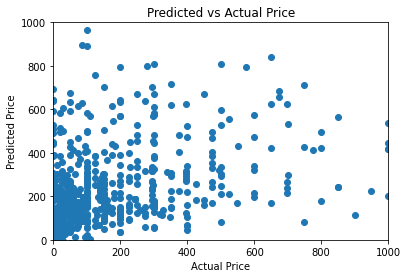

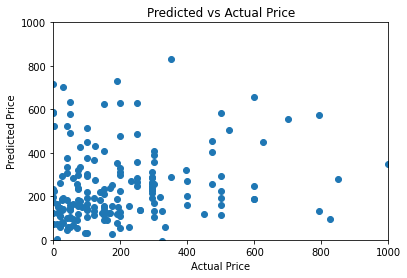

In [48]:
def scatter_predict_vs_actual(model, dataloader):
    # predict prices on validation set
    all_preds = []
    all_prices = []
    with torch.no_grad():
        for x, y in dataloader:
            model.eval()
            preds = model(x) # (batch_size, 1)
            all_preds.append(preds.numpy())
            all_prices.append(y.numpy())

    # flatten lists
    all_preds = np.concatenate(all_preds)
    all_prices = np.concatenate(all_prices)

    # undo normalization
    all_preds = all_preds * std_price + mean_price
    all_prices = all_prices * std_price + mean_price

    # Scatter plot of predicted prices vs actual prices
    plt.scatter(all_prices, all_preds)
    plt.xlabel("Actual Price")
    plt.ylabel("Predicted Price")
    plt.title("Predicted vs Actual Price")
    # make axis the same scale
    plt.xlim(0, 1000)
    plt.ylim(0, 1000)

    plt.show()

scatter_predict_vs_actual(model, train_dataloader)
scatter_predict_vs_actual(model, valid_dataloader)